In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

### Mount the Google drive if needed

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy
    
os.chdir(os.path.join(basedir, 'neuralClosureModels'))

%load_ext autoreload

### Load modules

In [3]:
%autoreload 2

from src.utilities.DDE_Solver import ddeinttf
from src.utilities.helper_classes import * 
import src.solvers.neuralDDE_with_adjoint_accel_Exp as ndde
import src.bio_eqn_case.bio_eqn_1D_modcall_numpy as bio
from src.bio_eqn_case.Bio_Eqn_1D_Helper_Classes import * 

import time
import sys
from IPython.core.debugger import set_trace

import numpy as np
import scipy.interpolate
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from shutil import move
import pickle

print(tf.__version__) 

tf.keras.backend.set_floatx('float32')
import logging
tf.get_logger().setLevel(logging.ERROR)

2.6.0-dev20210501


## Define some useful classes

### Class for user-defined arguments

In [4]:
class bio_eq_nDDE_args(ndde.arguments, bio.bio_eqn_args):

    def __init__(self, batch_time = 12, batch_time_skip = 2, batch_size = 5, epochs = 500, learning_rate = 0.05, decay_rate = 0.95, test_freq = 1, plot_freq = 2, 
                 d_max = 1.1, rnn_nmax = 3, rnn_dt = 0.5, adj_data_size = 2,
                 model_dir = 'Bio1D_nDistDDE_testcase_v2/model_dir_test', restart = 0, val_percentage = 0.2,
                 T = 365.*2, nt = 365*2, nz = 50, z_max = -100, k_w = 0.067, alpha = 0.025, V_m = 1.5, I_0 = 158.075, 
                 K_u = 1., Psi = 1.46, Xi = 0.1, R_m = 1.5, Lambda = 0.06, gamma = 0.3, Tau = 0.145, 
                 Phi = 0.175, Omega = 0.041, T_bio_min = 10., T_bio_max = 30., wp = 0.65, wd = 8.0, 
                 K_zb = 0.0864, K_z0 = 100.*0.0864, gamma_K = 0.1, T_mld = 365, bio_model_low_complex = 'NPZ', bio_model_high_complex = 'NNPZD', isplot = True,
                 ode_alg_name = 'dopri5', nsteps = 1, is_tstart_zero = True): # add more arguments as needed
        
        if bio_model_low_complex == 'NPZ': state_dim = 3*nz
        elif bio_model_low_complex == 'NPZD': state_dim = 4*nz
        elif bio_model_low_complex == 'NNPZD': state_dim = 5*nz

        ndde.arguments.__init__(self, data_size = nt, batch_time = batch_time, batch_time_skip = batch_time_skip, batch_size = batch_size, epochs = epochs,
                           learning_rate = learning_rate, decay_rate = decay_rate, test_freq = test_freq, plot_freq = plot_freq, d_max = d_max, rnn_nmax = rnn_nmax, 
                           rnn_dt = rnn_dt, state_dim = state_dim, adj_data_size = state_dim, model_dir = model_dir, restart = restart, val_percentage = val_percentage, isplot = isplot, is_tstart_zero = is_tstart_zero)

        bio.bio_eqn_args.__init__(self, T = T, nt = nt, nz = nz, z_max = z_max, k_w = k_w, alpha = alpha, V_m = V_m, I_0 = I_0, K_u = K_u, Psi = Psi,
                    Xi = Xi, R_m = R_m, Lambda = Lambda, gamma = gamma, Tau = Tau, Phi = Phi, Omega = Omega, T_bio_min = T_bio_min, T_bio_max = T_bio_max,
                                  wp = wp, wd = wd, bio_model = bio_model_low_complex, K_zb = K_zb, K_z0 = K_z0, gamma_K = gamma_K, T_mld = T_mld)
        
        self.bio_args_for_high_complex = bio.bio_eqn_args(T = T, nt = nt, nz = nz, z_max = z_max, k_w = k_w, alpha = alpha, V_m = V_m, I_0 = I_0, K_u = K_u, Psi = Psi,
                    Xi = Xi, R_m = R_m, Lambda = Lambda, gamma = gamma, Tau = Tau, Phi = Phi, Omega = Omega, T_bio_min = T_bio_min, T_bio_max = T_bio_max,
                                  wp = wp, wd = wd, bio_model = bio_model_high_complex)
        
        self.bio_model_low_complex = bio_model_low_complex
        self.bio_model_high_complex = bio_model_high_complex
        self.ode_alg_name = ode_alg_name
        self.nsteps = nsteps

### Define the neural net architecture

In [5]:
class SimpleRNNConv1DCell(tf.keras.layers.Layer):
    
    def __init__(self, input_shape, filter_size, kernel_size, strides, activation = 'tanh', padding = 'valid', **kwargs):
        
        self.kernel_size = kernel_size
        self.filter_size = filter_size
        self.strides = strides
        
        self.state_size = tf.TensorShape([input_shape[-2], self.filter_size])
        self.output_size = tf.TensorShape([np.floor((input_shape[-2] - self.kernel_size)/self.strides).astype(int), self.filter_size])
        
        self.c_h_inp = tf.keras.layers.Conv1D(filters=filter_size, kernel_size=kernel_size, strides=1, activation=None, padding='same',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.c_h_h = tf.keras.layers.Conv1D(filters=filter_size, kernel_size=kernel_size, strides=1, activation=None, padding='same',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=False)
        
        self.c_out_h = tf.keras.layers.Conv1D(filters=filter_size, kernel_size=kernel_size, strides=strides, activation=activation, padding=padding,
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.act = tf.keras.layers.Activation(activation)
        
        super(SimpleRNNConv1DCell, self).__init__(**kwargs)

    def call(self, input_at_t, states_at_t):
        states_at_tp1 = self.c_h_inp(input_at_t) + self.c_h_h(states_at_t[0])
        states_at_tp1 = self.act(states_at_tp1)
        output_at_tp1 = self.c_out_h(states_at_tp1)
        return output_at_tp1, [states_at_tp1]

In [6]:
class BioConstrainLayer(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs):
        
        super(BioConstrainLayer, self).__init__(**kwargs)
        
        self.gamma = tf.Variable(0.1, trainable=True, constraint = self.constraint)
        
    def constraint(self, gamma):
        
        out = tf.where(gamma <= 1., tf.where(gamma >= 0., gamma, 0.), 1.)
        
        return out
        
        
    def call(self, input):
        
        N_channel = self.gamma * input
        P_channel = - input
        Z_channel = (1. - self.gamma) * input
        
        output = tf.concat([N_channel, P_channel, Z_channel], axis=-1)
        
        return output

In [7]:
class AddExtraChannel(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs):
        
        super(AddExtraChannel, self).__init__(**kwargs)

        
    def call(self, input, channels_to_add):
#         channels_to_add = tf.tile(channels_to_add, [input.shape[0], 1, 1])
        output = tf.concat([input, channels_to_add], axis=-1)
        
        return output

In [8]:
class DDEFuncMain(tf.keras.Model):

    def __init__(self, args, **kwargs):
        super(DDEFuncMain, self).__init__(**kwargs)

        self.rnn_layer = tf.keras.layers.RNN(SimpleRNNConv1DCell(input_shape = [args.nz, 3], 
                                                                 filter_size = 5, kernel_size = 1, strides = 1, 
                                                                 activation = 'swish'))
        
        self.depth = AddExtraChannel()
        
        self.c1 = tf.keras.layers.Conv1D(filters=7, kernel_size=1, strides=1, activation='swish',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.c2 = tf.keras.layers.Conv1D(filters=9, kernel_size=1, strides=1, activation='swish',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.c3 = tf.keras.layers.Conv1D(filters=9, kernel_size=1, strides=1, activation='swish',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.c4 = tf.keras.layers.Conv1D(filters=7, kernel_size=1, strides=1, activation='swish',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.c5 = tf.keras.layers.Conv1D(filters=5, kernel_size=1, strides=1, activation='swish',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.c6 = tf.keras.layers.Conv1D(filters=3, kernel_size=1, strides=1, activation='swish',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.c_out = tf.keras.layers.Conv1D(filters=1, kernel_size=1, strides=1, activation='linear',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.bio = BioConstrainLayer()
        
        self.flat = tf.keras.layers.Flatten('channels_first')
        
        self.args = args

    @tf.function
    def pass_layers(self, y_nn, channels_to_add=None):
        
        y_nn = self.layers[0](y_nn)
        y_nn = self.layers[1](y_nn, channels_to_add)
        
        for i in range(2, len(self.layers)):
            y_nn = self.layers[i](y_nn)
            
        return y_nn
    
    def call(self, y_nn, channels_to_add=None):
        
        y_nn = self.pass_layers(y_nn, channels_to_add)
        
        return y_nn 

In [9]:
class DiscDDEFunc(tf.keras.Model):

    def __init__(self, main, rom_model, args, **kwargs):
        super(DiscDDEFunc, self).__init__(**kwargs)
        
        self.main = main
        self.rom_model = rom_model
        self.args = args
        
    def process_input(self, y, t ,d, t_start):     
        input = []
        for i in np.flip(np.arange(d[0])): # d is a list and d[0] contains the number of steps, while d[1] contains the time-step value to skip
            input.append(tf.expand_dims(y(t - i*d[1]), axis=0))

        input = tf.concat(input, axis=0)
        input = tf.transpose(input, perm=[1, 0] + [i for i in range(2, input.shape.rank)])
        input = tf.expand_dims(input, axis=-1)
        input = tf.reshape(input, [input.shape[0], input.shape[1], tf.floor(self.args.state_dim / self.args.nz), -1])
        input = tf.transpose(input, perm=[i for i in range(0, input.shape.rank-2)] + [input.shape.rank-1, input.shape.rank-2])
        
        z = tf.tile(tf.expand_dims(tf.expand_dims(self.args.z, axis=-1), axis=0), [t_start.shape[0], 1, 1])
        I = tf.concat([tf.expand_dims(tf.expand_dims(self.args.I(t + t_start[i]), axis=-1), axis=0) for i in range(t_start.shape[0])], axis=0)
        
        channels_to_add = tf.concat([z, I], axis=-1)
        
        return input, channels_to_add

    def call_nn_part(self, input, channels_to_add):
        dy_dt = self.main(input, channels_to_add)
        return dy_dt
    
    def __call__(self, y, t ,d, t_start = np.array([0.])):
        
        y_nn, channels_to_add = self.process_input(y, t, d, t_start)

        dy_dt = self.call_nn_part(y_nn, channels_to_add) + self.rom_model(y, t, t_start)
        
        return dy_dt

### Initialize model related parameters

In [10]:
args = bio_eq_nDDE_args(batch_time = 6, batch_time_skip = 2, batch_size = 8, epochs = 350, learning_rate = 0.05, 
                        decay_rate = 0.97, test_freq = 1, plot_freq = 1, d_max = 5., rnn_nmax = 4+1, rnn_dt = 0.5, 
                        model_dir = 'Bio1D_nDDE_testcase_v3/model_dir_case11', restart = 0, val_percentage = 1.,
                        T = 182, nt = 182*10, nz = 20, z_max = -100, k_w = 0.067, alpha = 0.025, V_m = 1.5, I_0 = 158.075, 
                        K_u = 1., Psi = 1.46, Xi = 0.1, R_m = 1.5, Lambda = 0.06, gamma = 0.3, Tau = 0.145, 
                        Phi = 0.175, Omega = 0.041, T_bio_min = 10., T_bio_max = 30., wp = 0*0.65, wd = 0*8.0, 
                        K_zb = 0.0864, K_z0 = 100.*0.0864, gamma_K = 0.1, T_mld = 365, bio_model_low_complex = 'NPZ', 
                        bio_model_high_complex = 'NNPZD', isplot = True, ode_alg_name = 'dopri5', nsteps = 5, 
                        is_tstart_zero = False)

### Make a copy of the current script

In [11]:
testcase_dir = 'neuralClosureModels/testcases/Bio_Eqn_1D'
save_dir_obj = save_dir(args = args, basedir = basedir, testcase_dir = testcase_dir, save_user_inputs=False)

### Run Setup

Higher complexity model done!


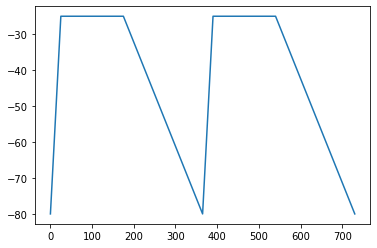

In [12]:
os.chdir(os.path.join(basedir, testcase_dir))

%run -i setup

In [13]:
class custom_plot:

    def __init__(self, true_y, y_no_nn, z, t, figsave_dir, args):
        self.true_y = true_y
        self.y_no_nn = y_no_nn
        self.t = t
        self.args = args
        self.figsave_dir = figsave_dir
        self.T, self.Z = np.meshgrid(t.numpy(), z.numpy())
        self.z = z
        
    def plot(self, pred_y):
        
        fig = plt.figure(figsize=(30, 5), facecolor='white')
        ax_N = fig.add_subplot(131)
        ax_P = fig.add_subplot(132)
        ax_Z = fig.add_subplot(133)
        
        B_N = tf.transpose(tf.squeeze(self.true_y[:, :, 0:self.args.nz], axis=1)).numpy()
        max_cbar_lim_N = np.max(B_N.flatten())
        B_P = tf.transpose(tf.squeeze(self.true_y[:, :, self.args.nz:2*self.args.nz], axis=1)).numpy()
        max_cbar_lim_P = np.max(B_P.flatten())
        B_Z = tf.transpose(tf.squeeze(self.true_y[:, :, 2*self.args.nz:3*self.args.nz], axis=1)).numpy()
        max_cbar_lim_Z = np.max(B_Z.flatten())
        
        self.plot_indiv(ax_N, 'True N (NNPZD)', B_N, max_cbar_lim_N)
        self.plot_indiv(ax_P, 'True P (NNPZD)', B_P, max_cbar_lim_P)
        self.plot_indiv(ax_Z, 'True Z (NNPZD)', B_Z, max_cbar_lim_Z)

        fig = plt.figure(figsize=(30, 5), facecolor='white')
        ax_N = fig.add_subplot(131)
        ax_P = fig.add_subplot(132)
        ax_Z = fig.add_subplot(133)
        
        B_N_diff = tf.transpose(tf.squeeze(tf.abs(self.true_y - self.y_no_nn)[:, :, 0:self.args.nz], axis=1)).numpy()
        max_cbar_lim_N_diff = np.max(B_N_diff.flatten())
        B_P_diff = tf.transpose(tf.squeeze(tf.abs(self.true_y - self.y_no_nn)[:, :, self.args.nz:2*self.args.nz], axis=1)).numpy()
        max_cbar_lim_P_diff = np.max(B_P_diff.flatten())
        B_Z_diff = tf.transpose(tf.squeeze(tf.abs(self.true_y - self.y_no_nn)[:, :, self.args.nz:2*self.args.nz], axis=1)).numpy()
        max_cbar_lim_Z_diff = np.max(B_Z_diff.flatten())
        
        self.plot_indiv(ax_N, '|Difference N (no NN)|', B_N_diff, max_cbar_lim_N_diff)
        self.plot_indiv(ax_P, '|Difference P (no NN)|', B_P_diff, max_cbar_lim_P_diff)
        self.plot_indiv(ax_Z, '|Difference Z (no NN)|', B_Z_diff, max_cbar_lim_Z_diff)
        
        fig = plt.figure(figsize=(30, 5), facecolor='white')
        ax_N = fig.add_subplot(131)
        ax_P = fig.add_subplot(132)
        ax_Z = fig.add_subplot(133)

        self.plot_indiv(ax_N, 'N (Learned)', tf.transpose(tf.squeeze(pred_y[:, :, 0:self.args.nz], axis=1)).numpy(), max_cbar_lim_N)
        self.plot_indiv(ax_P, 'P (Learned)', tf.transpose(tf.squeeze(pred_y[:, :, self.args.nz:2*self.args.nz], axis=1)).numpy(), max_cbar_lim_P)
        self.plot_indiv(ax_Z, 'Z (Learned)', tf.transpose(tf.squeeze(pred_y[:, :, 2*self.args.nz:3*self.args.nz], axis=1)).numpy(), max_cbar_lim_Z)

        fig = plt.figure(figsize=(30, 5), facecolor='white')
        ax_N = fig.add_subplot(131)
        ax_P = fig.add_subplot(132)
        ax_Z = fig.add_subplot(133)

        self.plot_indiv(ax_N, '|Difference N (with NN)|', tf.transpose(tf.squeeze(tf.abs(self.true_y - pred_y[:, :, :self.args.state_dim])[:, :, 0:self.args.nz], axis=1)).numpy(), max_cbar_lim_N_diff)
        self.plot_indiv(ax_P, '|Difference P (with NN)|', tf.transpose(tf.squeeze(tf.abs(self.true_y - pred_y[:, :, :self.args.state_dim])[:, :, self.args.nz:2*self.args.nz], axis=1)).numpy(), max_cbar_lim_P_diff)
        self.plot_indiv(ax_Z, '|Difference Z (with NN)|', tf.transpose(tf.squeeze(tf.abs(self.true_y - pred_y[:, :, :self.args.state_dim])[:, :, 2*self.args.nz:3*self.args.nz], axis=1)).numpy(), max_cbar_lim_Z_diff)
            
        plt.show()

        
    def plot_indiv(self, ax, title, B, max_cbar_lim):
        ax.cla()
        ax.set_title(title, fontsize=14)
        ax.set_ylabel('z', fontsize=14)
        ax.set_xlabel('t (days)', fontsize=14)
        plot = ax.contourf(self.T, self.Z, B, cmap=cm.coolwarm,
                           antialiased=False, levels=np.linspace(0, max_cbar_lim, 20), extend='both')
        ax.set_ylim(self.z[-1], self.z[0])
        ax.set_xlim(self.t[0], self.t[-1])
        cbar = plt.colorbar(plot, ax=ax, shrink=0.5, aspect=10)
        cbar.ax.tick_params(labelsize=12)
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        
            
    def plot_npz(self, B):
        fig = plt.figure(figsize=(14, 10), facecolor='white')
        ax_N = fig.add_subplot(221)
        ax_P = fig.add_subplot(222)
        ax_Z = fig.add_subplot(223)
        
        self.plot_indiv(ax_N, 'Nutrients', tf.transpose(tf.squeeze(B[:, :, 0:self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_P, 'Phytoplankton', tf.transpose(tf.squeeze(B[:, :, self.args.nz:2*self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_Z, 'Zooplankton', tf.transpose(tf.squeeze(B[:, :, 2*self.args.nz:3*self.args.nz], axis=1)).numpy())

        plt.show()
        
    def plot_nnpzd(self, B):
        fig = plt.figure(figsize=(14, 20), facecolor='white')
        ax_NO3 = fig.add_subplot(321)
        ax_NH4 = fig.add_subplot(322)
        ax_P = fig.add_subplot(323)
        ax_Z = fig.add_subplot(324)
        ax_D = fig.add_subplot(325)
        
        self.plot_indiv(ax_NO3, 'Nitrates', tf.transpose(tf.squeeze(B[:, :, 0:self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_NH4, 'Ammonia', tf.transpose(tf.squeeze(B[:, :, self.args.nz:2*self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_P, 'Phytoplankton', tf.transpose(tf.squeeze(B[:, :, 2*self.args.nz:3*self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_Z, 'Zooplankton', tf.transpose(tf.squeeze(B[:, :, 3*self.args.nz:4*self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_D, 'Detritus', tf.transpose(tf.squeeze(B[:, :, 4*self.args.nz:5*self.args.nz], axis=1)).numpy())

        plt.show()

## Main part starts here

### Make objects and define learning-rate schedule

In [14]:
rom_model = bio.bio_eqn(args, K_z_obj)
func_main = DDEFuncMain(args)
func = DiscDDEFunc(func_main, rom_model, args)

### Quick test to see how the true coefficients looks like

In [15]:
func.load_weights(tf.train.latest_checkpoint(save_dir_obj.checkpoint_dir))
pred_y = ddeinttf(func, x0_low_complex, tf.concat([t, val_t], axis=0), fargs=([args.rnn_nmax, args.rnn_dt],), alg_name = args.ode_alg_name, nsteps = args.nsteps)

/home/abhinavgupta0110/.local/lib/python3.8/site-packages/scipy/integrate/_ode.py:1181: UserWarning: dopri5: larger nsteps is needed
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


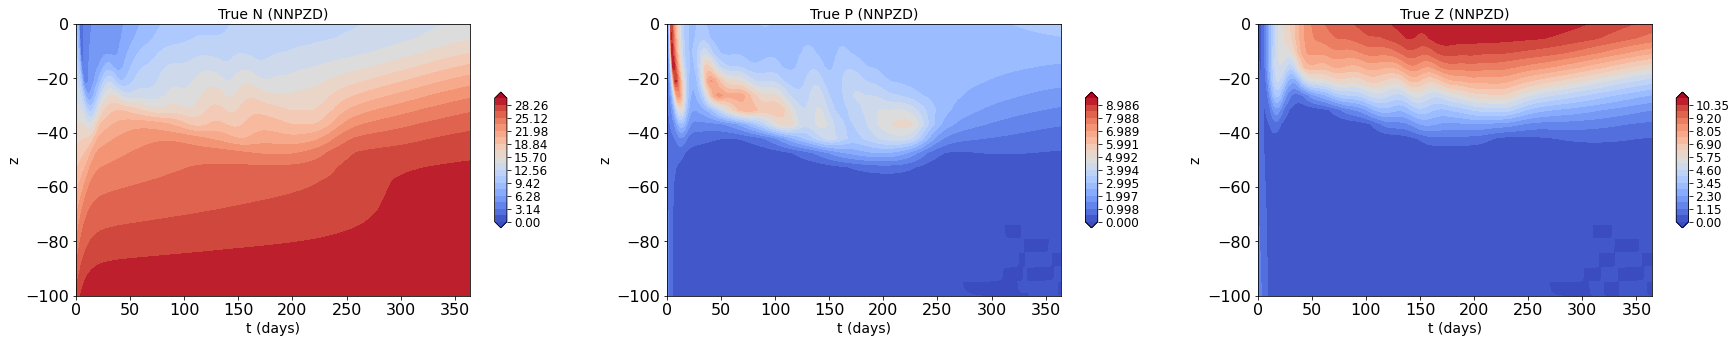

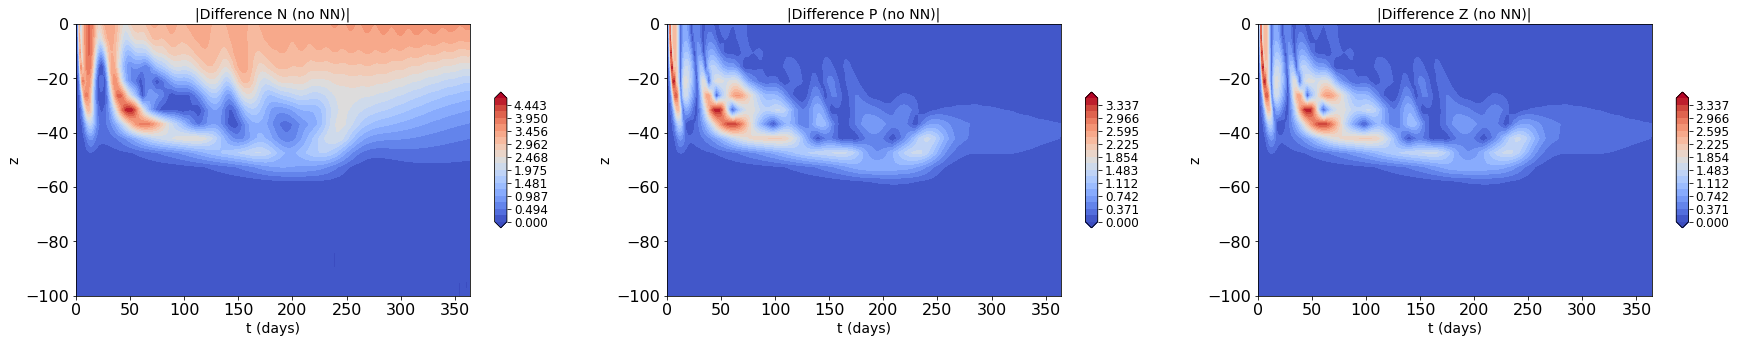

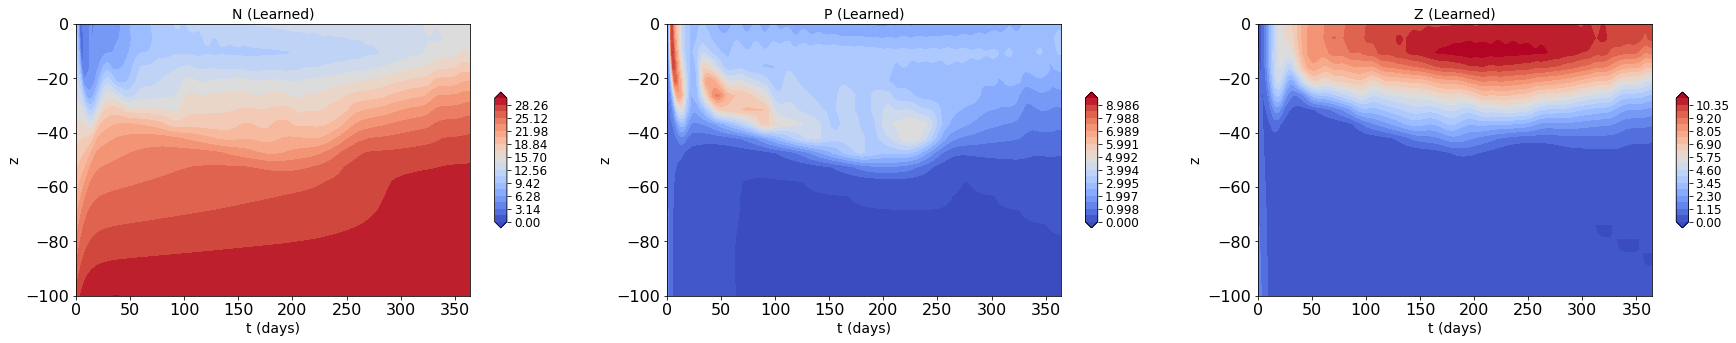

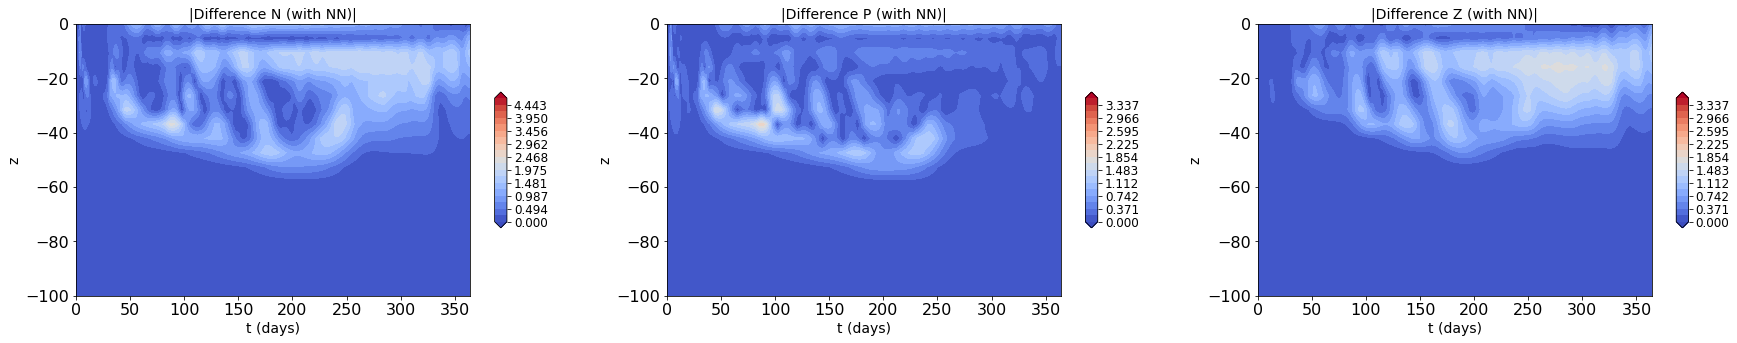

In [16]:
plot_obj = custom_plot(tf.concat([true_x_low_complex, val_true_x_low_complex], axis=0), tf.concat([x_low_complex, val_x_low_complex], axis=0), 
                       args.z, tf.concat([t, val_t], axis=0), save_dir_obj.figsave_dir, args)
plot_obj.plot(pred_y)

In [17]:
func_main.summary()

Model: "dde_func_main"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (RNN)                    multiple                  75        
_________________________________________________________________
add_extra_channel (AddExtraC multiple                  0         
_________________________________________________________________
conv1d_3 (Conv1D)            multiple                  56        
_________________________________________________________________
conv1d_4 (Conv1D)            multiple                  72        
_________________________________________________________________
conv1d_5 (Conv1D)            multiple                  90        
_________________________________________________________________
conv1d_6 (Conv1D)            multiple                  70        
_________________________________________________________________
conv1d_7 (Conv1D)            multiple                

In [18]:
class custom_plot_base:

    def __init__(self, z, t, args, K_obj = None):
        self.t = t
        self.args = args
        self.T, self.Z = np.meshgrid(t.numpy(), z.numpy())
        self.z = z
        self.K_obj = K_obj
        
    def plot(self, pred_y, title_start, title_end, max_cbar = None, cmap = cm.coolwarm):
        
        fig = plt.figure(figsize=(30, 5), facecolor='white')
        ax_N = fig.add_subplot(131)
        ax_P = fig.add_subplot(132)
        ax_Z = fig.add_subplot(133)
        
        B_N = tf.transpose(tf.squeeze(pred_y[:, :, 0:self.args.nz], axis=1)).numpy()
        B_P = tf.transpose(tf.squeeze(pred_y[:, :, self.args.nz:2*self.args.nz], axis=1)).numpy()
        B_Z = tf.transpose(tf.squeeze(pred_y[:, :, 2*self.args.nz:3*self.args.nz], axis=1)).numpy()
        
        if max_cbar == None:
            max_cbar = [np.max(B_N.flatten())]
            max_cbar.append(np.max(B_P.flatten()))
            max_cbar.append(np.max(B_Z.flatten()))
        
        self.plot_indiv(ax_N, title_start + ' N ' + title_end, B_N, max_cbar[0], cmap)
        self.plot_indiv(ax_P, title_start + ' P ' + title_end, B_P, max_cbar[1], cmap)
        self.plot_indiv(ax_Z, title_start + ' Z ' + title_end, B_Z, max_cbar[2], cmap)

        plt.show()
        
    def plot_with_mld(self, pred_y, title_start, title_end, max_cbar = None, cmap = cm.coolwarm):
        
        fig = plt.figure(figsize=(30, 5), facecolor='white')
        ax_N = fig.add_subplot(131)
        ax_P = fig.add_subplot(132)
        ax_Z = fig.add_subplot(133)
        
        B_N = tf.transpose(tf.squeeze(pred_y[:, :, 0:self.args.nz], axis=1)).numpy()
        B_P = tf.transpose(tf.squeeze(pred_y[:, :, self.args.nz:2*self.args.nz], axis=1)).numpy()
        B_Z = tf.transpose(tf.squeeze(pred_y[:, :, 2*self.args.nz:3*self.args.nz], axis=1)).numpy()
        
        if max_cbar == None:
            max_cbar = [np.max(B_N.flatten())]
            max_cbar.append(np.max(B_P.flatten()))
            max_cbar.append(np.max(B_Z.flatten()))
        
        self.plot_indiv_with_mld(ax_N, title_start + ' N ' + title_end, B_N, max_cbar[0], cmap)
        self.plot_indiv_with_mld(ax_P, title_start + ' P ' + title_end, B_P, max_cbar[1], cmap)
        self.plot_indiv_with_mld(ax_Z, title_start + ' Z ' + title_end, B_Z, max_cbar[2], cmap)

        plt.show()

        
    def plot_indiv(self, ax, title, B, max_cbar_lim, cmap):
        ax.cla()
        ax.set_title(title, fontsize=22)
        ax.set_ylabel('z (m)', fontsize=22)
        ax.set_xlabel('t (days)', fontsize=22)
        plot = ax.contourf(self.T, self.Z, B, cmap=cmap,
                           antialiased=False, levels=np.linspace(0, max_cbar_lim, 40), extend='both')
        ax.set_ylim(self.z[-1], self.z[0])
        ax.set_xlim(self.t[0], self.t[-1])
        cbar = plt.colorbar(plot, ax=ax, shrink=0.5, aspect=10)
        cbar.ax.tick_params(labelsize=12)
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        
    def plot_indiv_with_mld(self, ax, title, B, max_cbar_lim, cmap):
        ax.cla()
        ax.set_title(title, fontsize=22)
        ax.set_ylabel('z (m)', fontsize=22)
        ax.set_xlabel('t (days)', fontsize=22)
        plot = ax.contourf(self.T, self.Z, B, cmap=cmap,
                           antialiased=False, levels=np.linspace(0, max_cbar_lim, 40), extend='both')
        
        
        ax.plot(self.t, self.K_obj.M_intrp(self.t), linewidth=2, color='black')
        ax.set_ylim(self.z[-1], self.z[0])
        ax.set_xlim(self.t[0], self.t[-1])
        cbar = plt.colorbar(plot, ax=ax, shrink=0.5, aspect=10)
        cbar.ax.tick_params(labelsize=12)
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        
    def plot_solar_intensity(self):
        fig = plt.figure(figsize=(4, 1), facecolor='white')
        ax = fig.add_subplot(111)
        
        ax.plot(self.t, self.args.I_0_t(self.t), linewidth=2, color='black')
        ax.set_xlim(self.t[0], self.t[-1])
        ax.set_title('Solar Radiation', fontsize=14)
        ax.set_ylabel('$I_0$ (W $m^{-2}$)', fontsize=14)
        ax.set_xlabel('t (days)', fontsize=14)

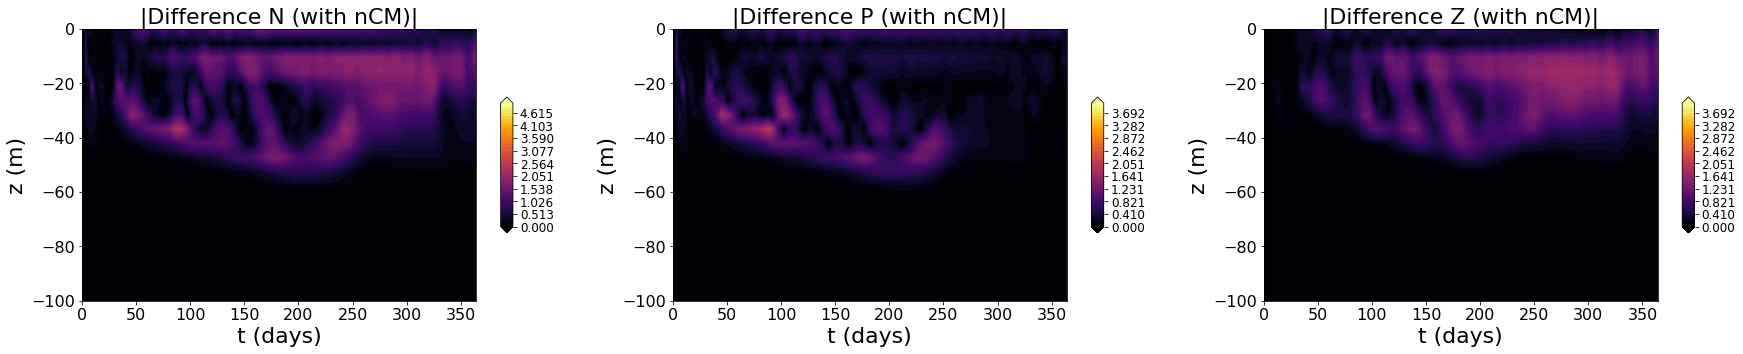

In [25]:
custom_plot_obj = custom_plot_base(args.z, tf.concat([t, val_t], axis=0), args, K_z_obj)

custom_plot_obj.plot(tf.abs(tf.concat([true_x_low_complex, val_true_x_low_complex], axis=0) - pred_y), '|Difference', '(with nCM)|', max_cbar = [5., 4., 4.], cmap=cm.inferno)

### Compute errors

In [20]:
class compute_error():
    
    def __init__(self, truth, thres = 0.02):
        self.truth = truth
        self.thres = thres
        
    def l2_error(self, pred):
        
        error = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.math.squared_difference(pred, self.truth), axis=-1)), axis=0)
        
        return error.numpy()
    
    def RMSE(self, pred):
        
        thres = tf.reduce_max(self.truth)*0.02
        error = []
        diff = pred - self.truth
        
        for i in range(1, pred.shape[0]):
            diff_t = np.abs(np.squeeze(diff[i, :, :].numpy()))
            error_t = diff_t[np.where(diff_t >= thres)]
            if len(error_t) == 0: continue
            error_t = np.sqrt(np.sum(error_t**2)/len(error_t))
            error.append(error_t)

        error = np.mean(np.array(error))
        return error

In [21]:
truth_all = tf.concat([true_x_low_complex, val_true_x_low_complex], axis=0)

In [22]:
truth = truth_all[:, :, 0:args.nz]

err_obj = compute_error(truth)

print('L2 error N: ', np.round(err_obj.l2_error(pred_y[:, :, 0:args.nz]), 3))

print('RMSE error (>2%) N: ', np.round(err_obj.RMSE(pred_y[:, :, 0:args.nz]), 3))

L2 error N:  [2.907]
RMSE error (>2%) N:  1.249


In [23]:
truth = truth_all[:, :, args.nz:2*args.nz]

err_obj = compute_error(truth)

print('L2 error P: ', np.round(err_obj.l2_error(pred_y[:, :, args.nz:2*args.nz]), 3))

print('RMSE error (>2%) P: ', np.round(err_obj.RMSE(pred_y[:, :, args.nz:2*args.nz]), 3))

L2 error P:  [1.424]
RMSE error (>2%) P:  0.568


In [24]:
truth = truth_all[:, :, 2*args.nz:3*args.nz]

err_obj = compute_error(truth)

print('L2 error Z: ', np.round(err_obj.l2_error(pred_y[:, :, 2*args.nz:3*args.nz]), 3))

print('RMSE error (>2%) Z: ', np.round(err_obj.RMSE(pred_y[:, :, 2*args.nz:3*args.nz]), 3))

L2 error Z:  [2.175]
RMSE error (>2%) Z:  0.831
